
# Optimal power flow model in Julia

In [4]:
import Pkg

# activate parent environment
Pkg.activate(normpath(joinpath(@__DIR__, ".")))
Pkg.resolve()
Pkg.instantiate()
Pkg.status()

using CSV
using DataFrames
using Dates
using CairoMakie
using JuMP
import JSON
import MathOptInterface as MOI

using Revise
using OptHP

  Activating project at `c:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort`
  No Changes to `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
  No Changes to `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Manifest.toml`


Status `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
  [336ed68f] CSV v0.10.15
  [13f3f980] CairoMakie v0.13.1
  [a93c6f00] DataFrames v1.7.0
  [682c06a0] JSON v0.21.4
  [4076af6c] JuMP v1.23.6
  [b8f27783] MathOptInterface v1.35.1
  [2d871509] OptHP v1.0.0-DEV `OptHP`
  [295af30f] Revise v3.7.1
  [ade2ca70] Dates


## Load data

In [5]:
network = CSV.read("data/network.csv", DataFrame)
first(network, 5)

Row,StartNode,EndNode,Length,cable,Inom,R,X
,Int64,Int64,Float64,String7,Float64,Float64,Float64
1,47,15,22.21,50Al,0.12528,0.0142366,0.00188785
2,49,40,15.57,95Al,0.18386,0.0049824,0.00127674
3,26,41,18.26,95Al,0.18386,0.0058432,0.00149732
4,11,12,6.71,95Al,0.18386,0.0021472,0.00055022
5,12,27,6.52,95Al,0.18386,0.0020864,0.00053464


In [6]:
connections = CSV.read("data/user_connect.csv", DataFrame; delim=";")

# convert PV (str) to Float64
connections.PV = parse.(Float64, replace.(connections.PV, "," => "."))

first(connections, 5)

Row,Column1,Name,Node.ID,Node.Unom,Length,Type short,Connection value,load,PV,HP,Node
,Int64,Int64,Int64,Int64,String7,String15,String7,Int64,Float64,Int64,Int64
1,1,871694840006284337,46559968,230,"21,75",XLPE 4x6Cu,3x25 A,7000,4.0,1,50
2,2,871694840006288793,46563894,230,"2,22",XLPE 4x6Cu,3x25 A,7000,6.0,0,51
3,3,871694840006284108,11195660,230,"10,4",PVC 4x16Al,1x35 A,2000,2.2,0,52
4,4,871694840006284115,11195660,230,"10,4",PVC 4x16Al,1x35 A,500,2.2,0,53
5,5,871694840006284092,2573422,230,"7,33",PVC 4x16Al,1x35 A,2000,2.2,0,54


In [7]:
loads_real = CSV.read("data/UserPower.csv", DataFrame)
loads_real.time = DateTime.(loads_real.time, "m/d/yyyy H:M p")

loads_reactive = CSV.read("data/UserReactivePower.csv", DataFrame)
loads_reactive.time = DateTime.(loads_reactive.time, "m/d/yyyy H:M p")

# Filter for rows where the date is February 1, 2024
date = Date(2024, 2, 1)
loads_real = loads_real[Date.(loads_real.time) .== date, 3:end]
loads_reactive = loads_reactive[Date.(loads_reactive.time) .== date, 3:end]
first(loads_real, 5)

Row,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0280492,0.0327633,0.00789328,0.00216432,0.00870451,0.0066902,0.0190303,0.0208217,0.0316786,0.00885476,0.00227458,0.0100109,0.00389288,0.00391422,0.0217207,0.00663473,0.0137514,0.038904,0.0160743,0.0134882,0.0108427,0.044233,0.00783649,0.00964245,0.0327462,0.0462532,0.0159094,0.0085621,0.0220982,0.00783409,0.00924792,0.0118713,0.025677,0.019321,0.0138463,0.0255821,0.0
2,0.0194261,0.0201885,0.00556897,0.00150743,0.00557323,0.00408914,0.0129535,0.0161562,0.0188356,0.00547041,0.00150153,0.00703371,0.00301253,0.00301947,0.0136849,0.00469629,0.0110687,0.0308354,0.0108854,0.0103217,0.00754248,0.0315925,0.00559041,0.00759827,0.0213481,0.0281427,0.0101261,0.00647718,0.0135207,0.00579418,0.00582512,0.00873516,0.018251,0.013007,0.00943072,0.0178395,0.0
3,0.0222562,0.0222175,0.00583958,0.00149652,0.00583324,0.0040186,0.0131774,0.0146778,0.0221186,0.0063148,0.00160216,0.00741227,0.00291713,0.00310672,0.0151385,0.00471799,0.0109297,0.0284821,0.0112424,0.00954143,0.00796256,0.0309558,0.00559076,0.00797005,0.0227603,0.0303833,0.0111911,0.0058502,0.0160791,0.00646978,0.00603232,0.00961901,0.0193459,0.0125066,0.00844744,0.0178119,0.0
4,0.0236077,0.0214192,0.00656782,0.00158927,0.00727005,0.00480448,0.0148979,0.0172582,0.021615,0.00741563,0.00154189,0.00765452,0.00309739,0.00323702,0.0160809,0.00554229,0.012016,0.0365018,0.0146685,0.0129499,0.00916666,0.0329395,0.00737826,0.00877966,0.0230161,0.0328368,0.0108052,0.00674518,0.0164615,0.00639536,0.00619007,0.0105051,0.0187594,0.0137561,0.010025,0.020322,0.0
5,0.0258527,0.026771,0.00830569,0.00182058,0.00881239,0.00562766,0.0188999,0.0181352,0.0267452,0.00775641,0.00204764,0.00959481,0.00368743,0.00390459,0.0200733,0.00636839,0.0138178,0.0417959,0.0160488,0.0146582,0.00963903,0.0412269,0.00812958,0.00960557,0.0266,0.0380806,0.0141561,0.00851961,0.0213948,0.00755007,0.00783836,0.0122754,0.0233571,0.0186267,0.0109073,0.0241358,0.0


## Load state-space matrices

In [8]:
id = "H14"

A_d = Matrix(CSV.read("data/$(id)/$(id)_15min_A_exact.csv", DataFrame))
B_d = Matrix(CSV.read("data/$(id)/$(id)_15min_B_exact.csv", DataFrame))

H14_meta = Dict(
    "A" => A_d,
    "B" => B_d
)

meta = Dict(
    "H14" => H14_meta
)

Dict{String, Dict{String, Matrix{Float64}}} with 1 entry:
  "H14" => Dict("B"=>[0.00663784 0.00224598 0.166439; 9.37536e-5 2.65051e-6 0.0…

## Read weather data

In [9]:
weather_df = CSV.read("data/weather/weather.csv", DataFrame)
rename!(weather_df, Dict("P_solar" => "Φ_s", "T_ambient" => "T_a"))
first(weather_df, 5)

Row,Φ_s,T_a,timestamp,interpolated
,Int64,Float64,String31,Bool
1,0,9.5,2023-09-01T00:00:00.000+00:00,false
2,0,9.4,2023-09-01T00:10:00.000+00:00,false
3,0,9.5,2023-09-01T00:20:00.000+00:00,false
4,0,9.6,2023-09-01T00:30:00.000+00:00,false
5,0,9.5,2023-09-01T00:40:00.000+00:00,false


## Construct GEC

In [10]:
model = GEC(network=network, 
            connections=connections, 
            loads_real=loads_real .* 1E-3, 
            loads_reactive=loads_reactive .* 1E-3,   
            weather=weather_df,    
            meta = meta,
            silent=false 
)

Set parameter Username
Set parameter LicenseID to value 2599292
Academic license - for non-commercial use only - expires 2025-12-13
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 9 5950X 16-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 69792 rows, 78912 columns and 177024 nonzeros
Model fingerprint: 0x6f587b17
Model has 96 quadratic constraints
Variable types: 75456 continuous, 3456 integer (3456 binary)
Coefficient statistics:
  Matrix range     [1e-07, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e-02, 4e+02]
  Bounds range     [5e-02, 6e+01]
  RHS range        [9e-09, 1e+01]
  QRHS range       [1e-02, 1e-02]
Presolve removed 69573 rows and 78613 columns
Presolve time: 0.30s
Presolved: 219 rows, 299 columns, 999 nonzeros
Variable types: 287 continuous, 12 integer (12 binary)
Found heuristic solution: objectiv

A JuMP Model
├ solver: Gurobi
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 78912
├ num_constraints: 126156
│ ├ AffExpr in MOI.EqualTo{Float64}: 47328
│ ├ AffExpr in MOI.GreaterThan{Float64}: 2400
│ ├ AffExpr in MOI.LessThan{Float64}: 20064
│ ├ QuadExpr in MOI.LessThan{Float64}: 96
│ ├ VariableRef in MOI.EqualTo{Float64}: 36
│ ├ VariableRef in MOI.GreaterThan{Float64}: 37524
│ ├ VariableRef in MOI.LessThan{Float64}: 15252
│ └ VariableRef in MOI.ZeroOne: 3456
└ Names registered in the model
  └ :I_line, :J_hp, :J_loss, :J_pv, :P, :P_HP, :P_hp, :P_hp_down, :P_line, :P_load_user, :P_pv, :P_pv_down, :Q, :Q_hp, :Q_line, :Q_pv, :Te, :V, :g, :t_l, :t_u, :u, :z_CV, :z_HP, :z_hp, :ΔT, :Φ_CV, :Φ_HP, :Φ_h, :η_COP

In [11]:
solution_summary(model)

* Solver : Gurobi

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 2.30400e+06
  Objective bound    : 2.30400e+06
  Relative gap       : 0.00000e+00
  Dual objective value : 2.30400e+06

* Work counters
  Solve time (sec)   : 3.16000e-01
  Simplex iterations : 0
  Barrier iterations : 0
  Node count         : 0


In [12]:
function prepare_solution(model)
    # prepare JuMP solution for plotting
    sol = Dict{Symbol, Vector{Float64}}()
    for var in [:Q, :P_pv, :P_hp, :P_hp_down, :P_pv_down]
        sol[var] = vec(sum(Matrix{Float64}(value.(model[var]; result=1)), dims=2)) .* 1E3
    end

    # some solutions have to be corrected
    for var in [:Q]
        sol[var] = sol[var] .* -1
    end
    return sol
end

prepare_solution (generic function with 1 method)

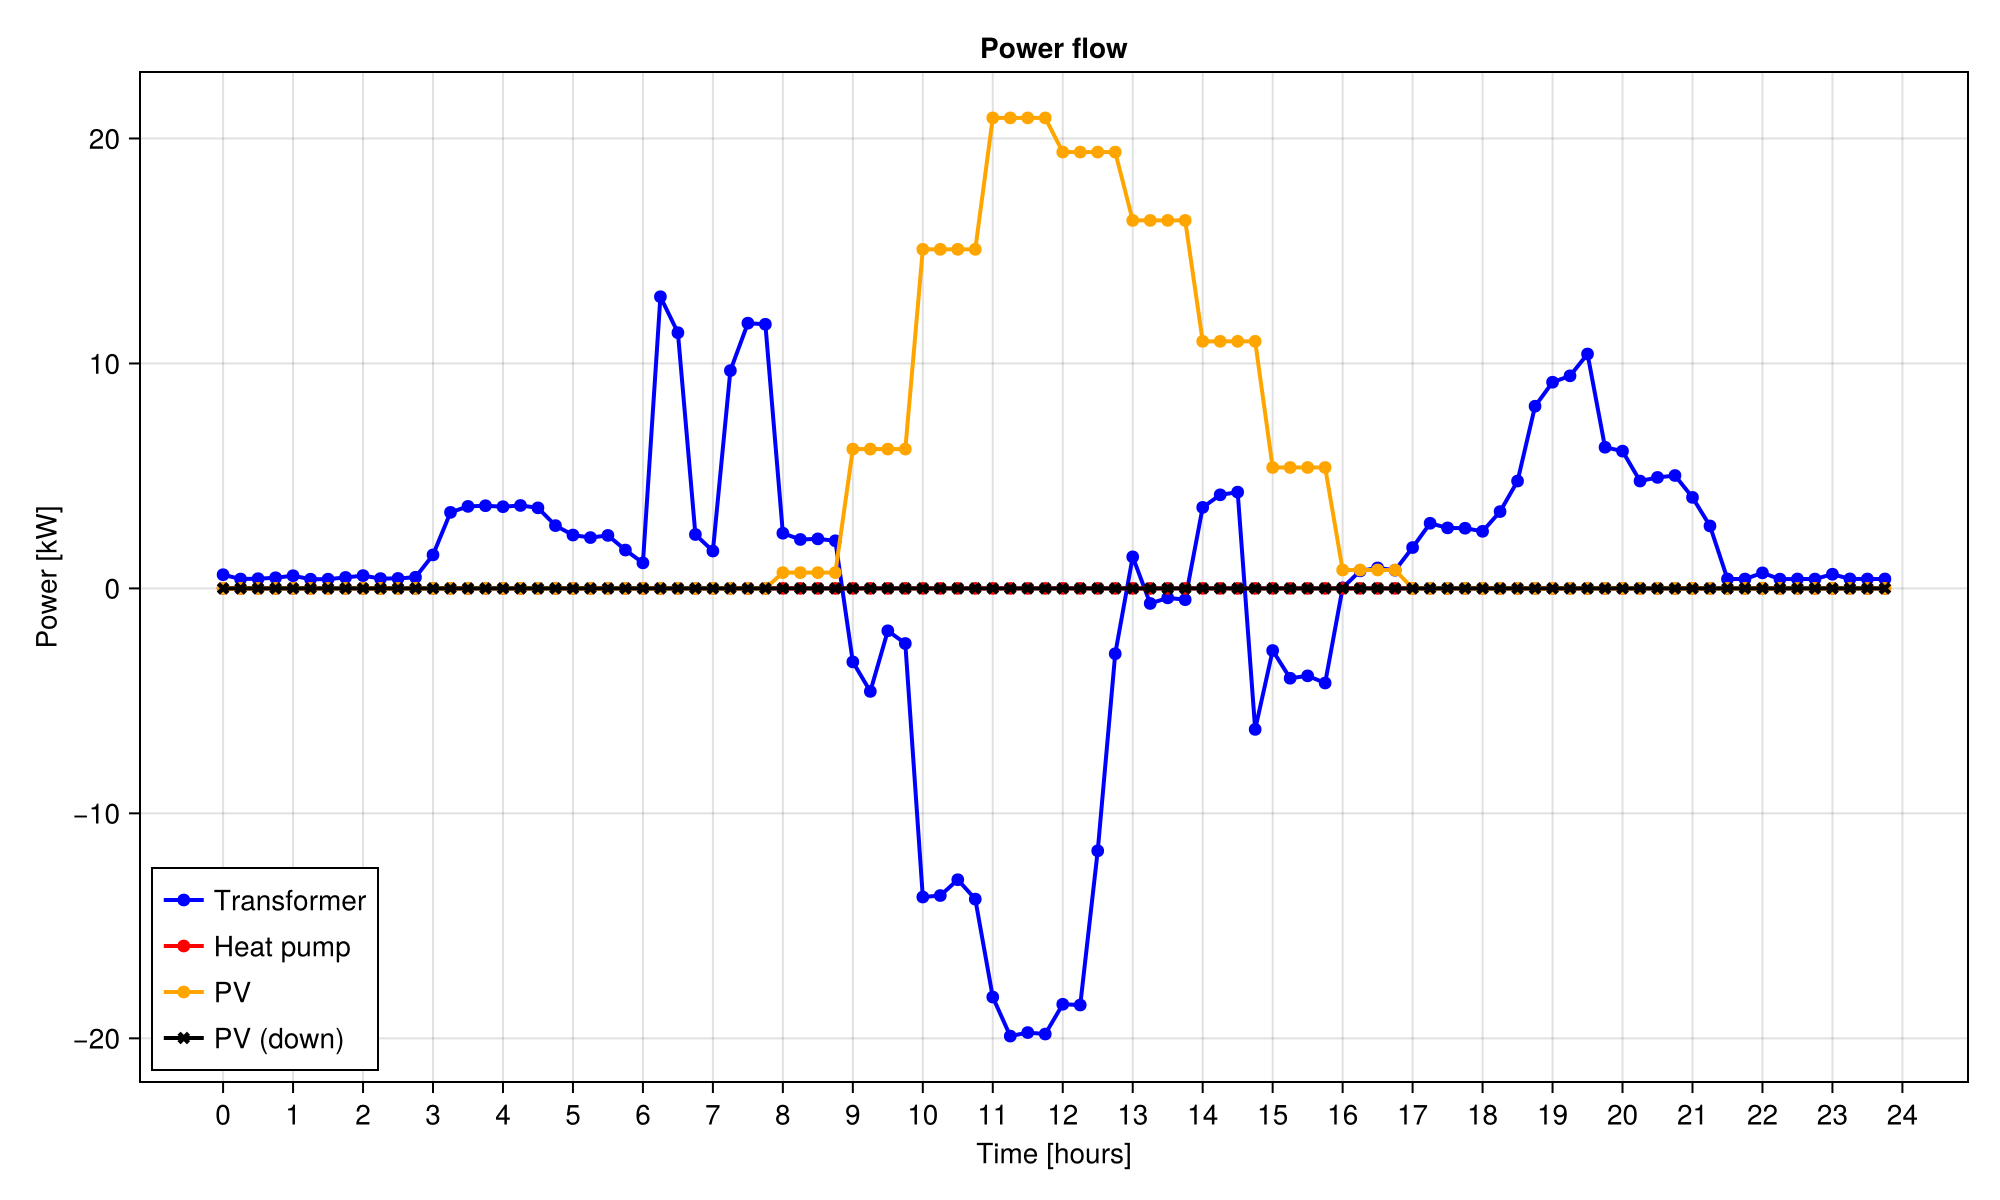

In [13]:
sol = prepare_solution(model)

# plot using Makie
fig = Figure(; size = (1000, 600))
ax = Axis(fig[1, 1], xlabel = "Time [hours]", 
    ylabel = "Power [kW]", 
    title = "Power flow",
    xticks = (1:4:97, string.(0:1:24))
)

# index of slack bus (transformer)
SB = argmin(value.(model[:P]).axes[2])
P_trafo = Matrix(value.(model[:P]; result=1))[:, SB] .* -1E3


# lines!(ax, sol[:P], color = :blue, label = "Transformer", linestyle = :so
scatterlines!(ax, P_trafo, color = :blue, label = "Transformer", linewidth = 2)
# scatterlines!(ax, sol[:Q], color = :green, label = "Reactive power", linewidth = 2)
scatterlines!(ax, sol[:P_hp], color = :red, label = "Heat pump", linewidth = 2)
scatterlines!(ax, sol[:P_pv], color = :orange, label = "PV", linewidth = 2)
# scatterlines!(ax, sol[:P_hp_down], color = :purple, label = "Heat pump (down)", marker=:cross, linewidth = 2)
scatterlines!(ax, sol[:P_pv_down], color = :black, label = "PV (down)", marker=:x, linewidth = 2)
# fig[1, 2] = Legend(fig, ax)
axislegend(ax, merge = true, position = :lb)

# display
fig

## Plot total user power consumption

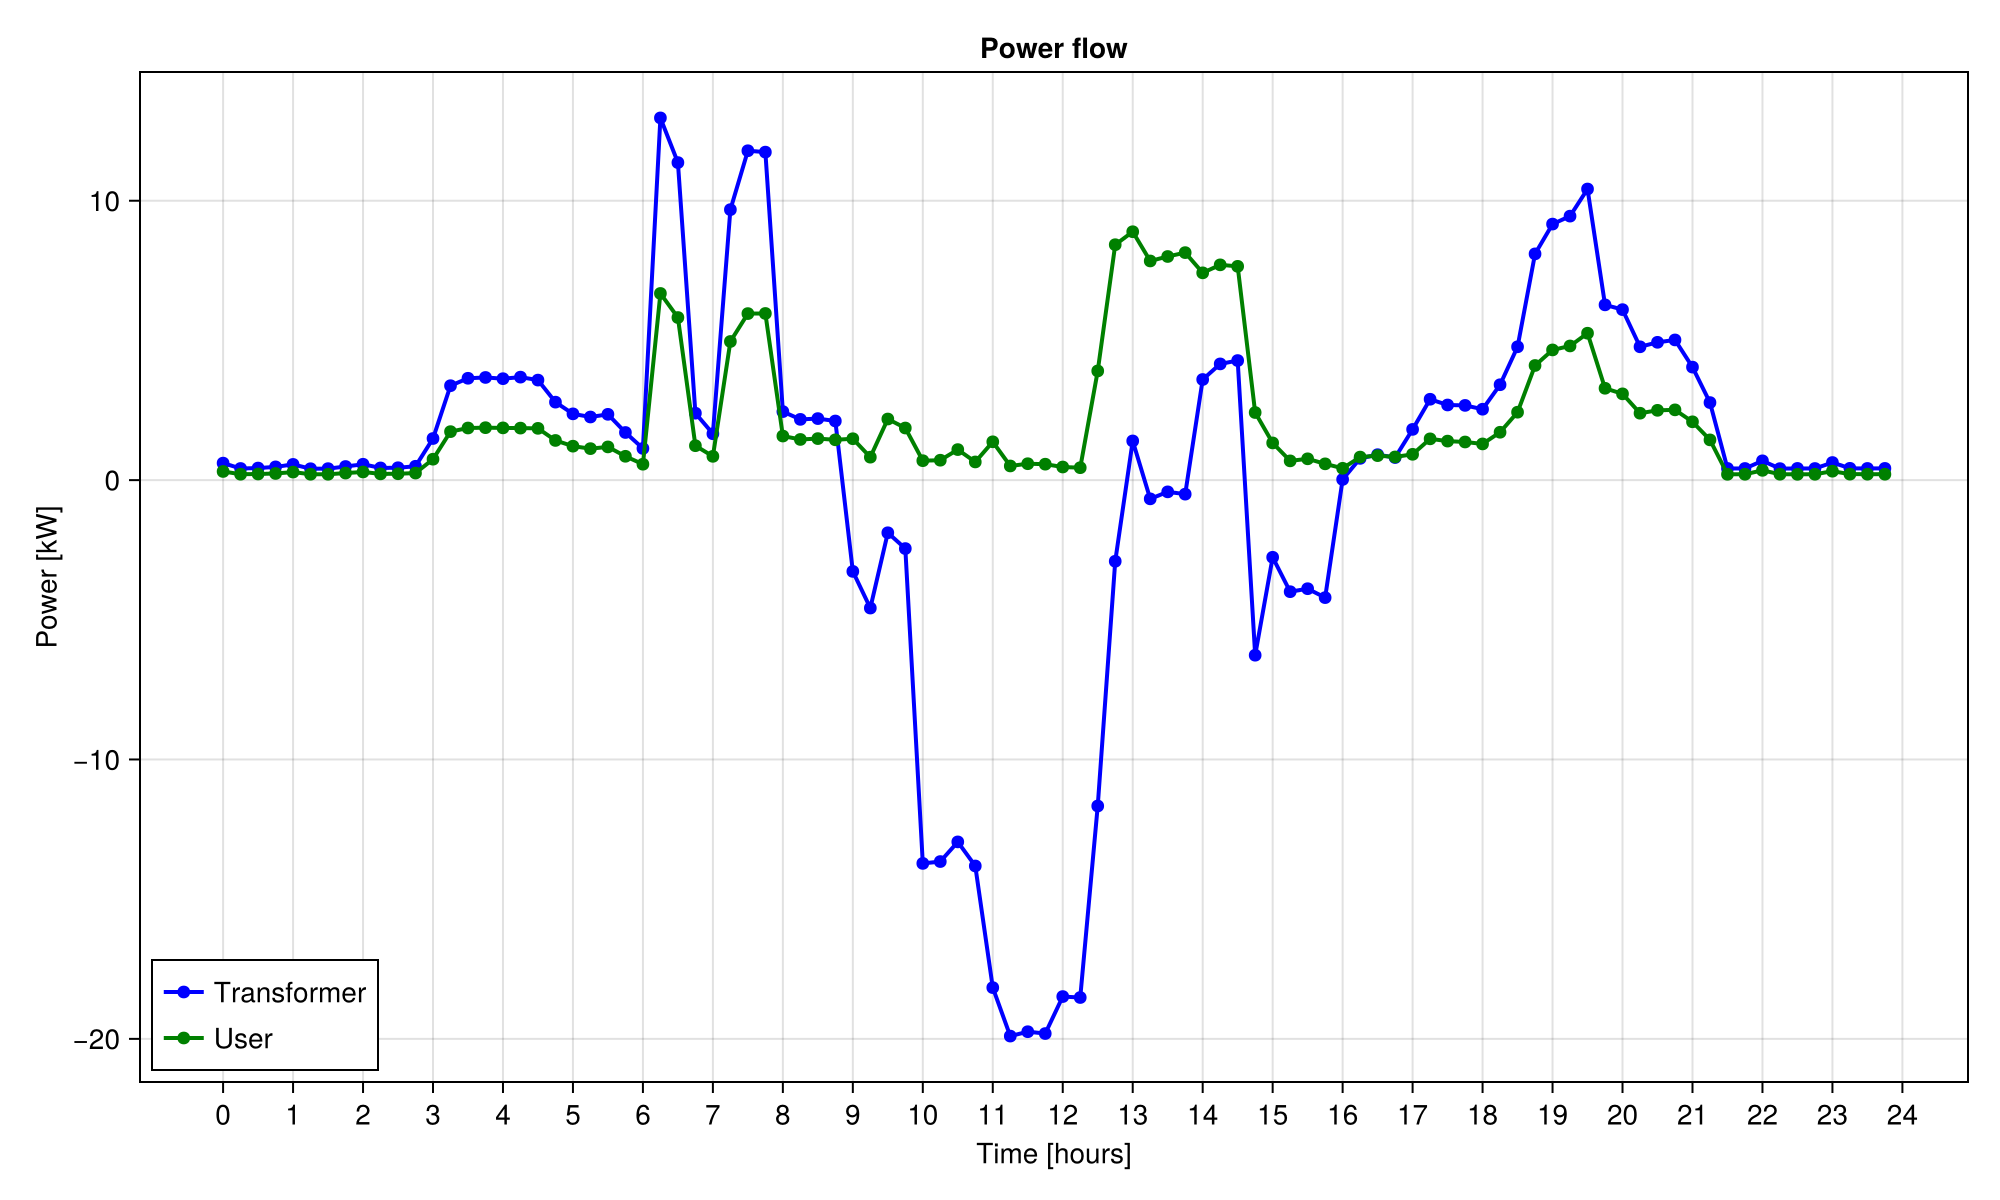

In [14]:
# plot using Makie
fig = Figure(; size = (1000, 600))
ax = Axis(fig[1, 1], xlabel = "Time [hours]", 
    ylabel = "Power [kW]", 
    title = "Power flow",
    xticks = (1:4:97, string.(0:1:24))
)

# transformer power
scatterlines!(ax, P_trafo, color = :blue, label = "Transformer", linewidth = 2)

# total user power
P_load_user = Vector(value.(model[:P_load_user]; result=1)) .* 1E3
scatterlines!(ax, P_load_user, color = :green, label = "User", linewidth = 2)

# display
axislegend(ax, merge = true, position = :lb)
fig

In [15]:
value.(model[:P_line])[10, (34,0)] .* -1E3

0.43670802030373185

In [16]:
value.(model[:P_line])

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:96
    Dimension 2, [(20, 13), (32, 84), (40, 11), (18, 79), (25, 83), (15, 43), (6, 21), (47, 15), (28, 34), (3, 75)  …  (8, 68), (21, 29), (33, 60), (29, 52), (15, 39), (17, 41), (23, 47), (27, 63), (12, 27), (10, 20)]
And data, a 96×86 Matrix{Float64}:
 1.90303e-5  1.38463e-5  -0.000591002  …  -0.000604905  -5.26554e-5
 1.29535e-5  9.43072e-6  -0.000403584     -0.00041363   -4.19041e-5
 1.31774e-5  8.44744e-6  -0.000418581     -0.00042891   -3.94118e-5
 1.48979e-5  1.0025e-5   -0.000459828     -0.00047058   -4.85178e-5
 1.88999e-5  1.09073e-5  -0.00054558      -0.000558862  -5.56137e-5
 1.19932e-5  9.50234e-6  -0.000395355  …  -0.000405002  -3.69728e-5
 1.29887e-5  8.22571e-6  -0.000397393     -0.000407878  -3.76973e-5
 1.5162e-5   9.31324e-6  -0.000471869     -0.000483685  -4.49739e-5
 1.66913e-5  1.16785e-5  -0.000549104     -0.00056428   -5.04028e-5
 1.40195e-5  9.8962e-6   -0.000421943     -0.0004333